In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

In [2]:
# Skip date

df1 = pd.read_csv(r'C:\Users\HP\Desktop\BE data\ml-latest-small\ratings.csv', header = None, names = ['Cust_Id','Movie_Id','Rating'],usecols = [0,1,2])
df1 = df1[['Cust_Id','Rating','Movie_Id']]
#df1.columns = df1.columns.str.strip()

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::1, :])


Dataset 1 shape: (100836, 3)
-Dataset examples-
        Cust_Id  Rating  Movie_Id
0             1     4.0         1
1             1     4.0         3
2             1     4.0         6
3             1     5.0        47
4             1     5.0        50
5             1     3.0        70
6             1     5.0       101
7             1     4.0       110
8             1     5.0       151
9             1     5.0       157
10            1     5.0       163
11            1     5.0       216
12            1     3.0       223
13            1     5.0       231
14            1     4.0       235
15            1     5.0       260
16            1     3.0       296
17            1     3.0       316
18            1     5.0       333
19            1     4.0       349
20            1     4.0       356
21            1     5.0       362
22            1     4.0       367
23            1     3.0       423
24            1     4.0       441
25            1     5.0       457
26            1     4.0       480


In [3]:
# # load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::1, :])

Full dataset shape: (100836, 3)
-Dataset examples-
        Cust_Id  Rating  Movie_Id
0             1     4.0         1
1             1     4.0         3
2             1     4.0         6
3             1     5.0        47
4             1     5.0        50
5             1     3.0        70
6             1     5.0       101
7             1     4.0       110
8             1     5.0       151
9             1     5.0       157
10            1     5.0       163
11            1     5.0       216
12            1     3.0       223
13            1     5.0       231
14            1     4.0       235
15            1     5.0       260
16            1     3.0       296
17            1     3.0       316
18            1     5.0       333
19            1     4.0       349
20            1     4.0       356
21            1     5.0       362
22            1     4.0       367
23            1     3.0       423
24            1     4.0       441
25            1     5.0       457
26            1     4.0       4

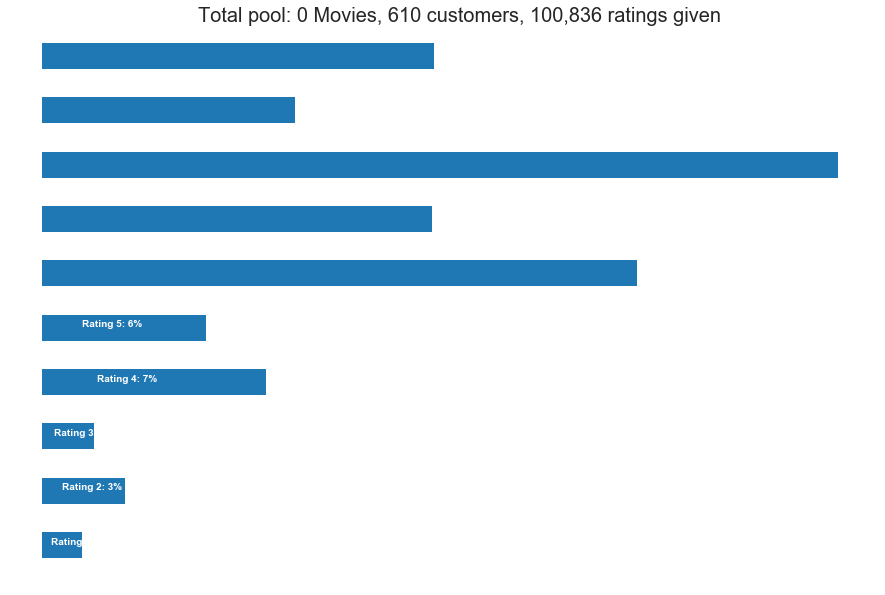

In [4]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [5]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.0),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.0),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1.0
Customer minimum times of review: 20.0


In [6]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::1, :])

Original Shape: (100836, 3)
After Trim Shape: (100836, 3)
-Data Examples-
        Cust_Id  Rating  Movie_Id
0             1     4.0         1
1             1     4.0         3
2             1     4.0         6
3             1     5.0        47
4             1     5.0        50
5             1     3.0        70
6             1     5.0       101
7             1     4.0       110
8             1     5.0       151
9             1     5.0       157
10            1     5.0       163
11            1     5.0       216
12            1     3.0       223
13            1     5.0       231
14            1     4.0       235
15            1     5.0       260
16            1     3.0       296
17            1     3.0       316
18            1     5.0       333
19            1     4.0       349
20            1     4.0       356
21            1     5.0       362
22            1     4.0       367
23            1     3.0       423
24            1     4.0       441
25            1     5.0       457
26      

In [7]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(610, 9724)


In [8]:
df_title = pd.read_csv(r'C:\Users\HP\Desktop\BE data\data\mlmoviestest.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Name'], usecols = [0,1])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(100))

                                                       Name
Movie_Id                                                   
1                                                Toy Story 
2                                            Jumanji (1995)
3                                   Grumpier Old Men (1995)
4                                  Waiting to Exhale (1995)
5                        Father of the Bride Part II (1995)
6                                               Heat (1995)
7                                            Sabrina (1995)
8                                       Tom and Huck (1995)
9                                       Sudden Death (1995)
10                                         GoldenEye (1995)
11                           American President, The (1995)
12                       Dracula: Dead and Loving It (1995)
13                                             Balto (1995)
14                                             Nixon (1995)
15                                  Cutt

In [9]:
df = df1
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(610, 9724)


In [10]:
print(df_p)

Movie_Id  1       2       3       4       5       6       7       8       \
Cust_Id                                                                    
1            4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5            4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
6            NaN     4.0     5.0     3.0     5.0     4.0     4.0     3.0   
7            4.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8            NaN     4.0     NaN     NaN     NaN     NaN     NaN     NaN   
9            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
11           NaN     NaN     NaN     NaN     NaN     5.0     NaN     NaN   
12          

In [11]:
movie_data = pd.merge(df, df_title, on='Movie_Id')  

In [12]:
movie_data.head() 

,Cust_Id,Rating,Movie_Id,Name
0,1,4.0,1,Toy Story
1,5,4.0,1,Toy Story
2,7,4.5,1,Toy Story
3,15,2.5,1,Toy Story
4,17,4.5,1,Toy Story


In [13]:
movie_data.groupby('Name')['Rating'].mean().head()  

Name
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: Rating, dtype: float64

In [14]:
movie_data.groupby('Name')['Rating'].mean().sort_values(ascending=False).head()  

Name
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: Rating, dtype: float64

In [15]:
movie_data.groupby('Name')['Rating'].count().sort_values(ascending=False).head()  

Name
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: Rating, dtype: int64

In [16]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('Name')['Rating'].mean())

In [17]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('Name')['Rating'].count()) 

In [18]:
ratings_mean_count.head()  

,Rating,rating_counts
Name,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [19]:
user_movie_rating = movie_data.pivot_table(index='Cust_Id', columns='Name', values='Rating')  
user_movie_rating.head()  

Name,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]Â² (2009),[REC]Â³ 3 GÃ©nesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),Â¡Three Amigos! (1986),Ã nous la libertÃ© (Freedom for Us) (1931)
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
after_hours_ratings = user_movie_rating['After Hours (1985)']  

In [21]:
after_hours_ratings.head()

Cust_Id
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: After Hours (1985), dtype: float64

In [25]:
movies_like_after_hours = user_movie_rating.corrwith(after_hours_ratings)

corr_after_hours = pd.DataFrame(movies_like_after_hours, columns=['Correlation'])  
corr_after_hours.dropna(inplace=True)  
corr_after_hours.head(50)  

,Correlation
Name,
(500) Days of Summer (2009),0.000000
10 Things I Hate About You (1999),0.188982
12 Angry Men (1957),1.000000
13 Assassins (JÃ»san-nin no shikaku) (2010),1.000000
2001: A Space Odyssey (1968),-0.628619
24 Hour Party People (2002),1.000000
25th Hour (2002),1.000000
28 Days Later (2002),0.866025
30 Days of Night (2007),1.000000


In [24]:
corr_after_hours.to_csv(r'C:\Users\HP\Desktop\BE data\mlop.csv', sep='\t', encoding='utf-8')